# Campaign management
Predict Interaction rate from ad texts

In [2]:
from fastai import *
from fastai.text import *
import os
import pathlib as path
import pandas as pd
import re

### Data loading and cleaning

In [ ]:
HOME = path.Path('/home/jovyan/work')
DATA = HOME/'data'
MODELS = DATA/'corpus/models'
bs = 256 # Batch size
df = pd.read_csv(DATA/'podaci.csv', header=2,  error_bad_lines=True, low_memory=False)
print(df.shape)

In [1]:
df.shape

NameError: name 'df' is not defined

In [3]:
# Bye totals
df.drop(df.tail(350).index,inplace=True)

In [4]:
# Now let's delete all rows with no Impressions and Image ads
df = df.drop(df[(df['Impr.'] == '0') | (df["Ad type"] == 'Image ad') | (df["Ad type"] == 'Display ad')].index)

In [5]:
# Clean and preprocess text
def clean_text(dirty_text):
  text = re.sub(r'http\S+','', str(dirty_text))
  punctuation = '.!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  text = text.lower()
  #remove numbers
  # text = text.replace("[0-9]", "")
  text = re.sub("[0-9]", "", text)
  # Remove Keywords, KeyWords
  text = re.sub('keyword','', text, flags=re.IGNORECASE)
  # Remove whitespaces
  text = ' '.join(text.split())
  return text

In [6]:
df_clean = df.Headline.map(clean_text) + ' ' + df['Headline 1'].map(clean_text) + ' ' + df['Headline 2'].map(clean_text)  + ' ' + df['Headline 3'].map(clean_text) + ' '+  df['Headline 4'].map(clean_text)+ ' '+ df['Headline 5'].map(clean_text) + ' '+ df.Description.map(clean_text) + ' '+ df['Description 1'].map(clean_text) + ' '+ df['Description 2'].map(clean_text)+ ' '+ df['Description 3'].map(clean_text)+ df['Description 4'].map(clean_text)+ ' '+ df['Description 5'].map(clean_text)

In [7]:
df_train = pd.concat([df_clean,df['Avg. cost']], axis= 1)
df_train.columns = ['text', 'cost']
df_train = df_train[df_train.cost.str.strip() != '--'] 
df_train.rate = df_train.cost.apply(lambda x: float(x))
print(df_train.shape)
df_train.head()

(68819, 2)


/home/jovyan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


,text,cost
194,hladnjaci online prodaja dodatnih popusta ...,1.47
221,božićni ukrasi veliki izbor na jednom mjestu ...,0.53
426,ekupi igre za djevojčice razne igre i ig...,0.28
522,usisavači late night shopping novi usisava...,1.85
778,ploče za kuhanje više od modela u prodaji ...,1.39


### Training regression

In [9]:
vocab = Vocab.load(MODELS/'raw_campaign_vocab.pkl')

In [11]:
# See possible approaches https://forums.fast.ai/t/regression-using-fine-tuned-language-model/29091/56
data_regr = (TextList.from_df(df=df_train, path=DATA, cols='text', vocab=vocab)
             .split_by_rand_pct(0.2)
             .label_from_df('cost', label_cls=FloatList)
             .databunch(bs=bs))

/home/jovyan/.local/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
# Loss function - mse, optimizer - Adam ()-default, last layer - Sigmoid
learn = text_classifier_learner(data_regr, 
                                arch = AWD_LSTM, 
                                drop_mult=0.3,
                                metrics = rmse)
learn.loss_func = MSELossFlat()
learn.load_encoder(MODELS/'campaign_enc')
learn.freeze()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


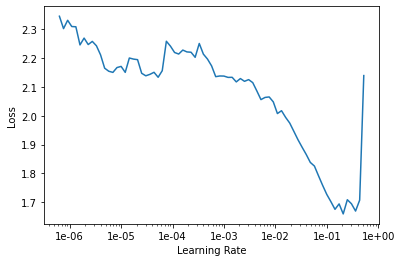

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.460829,0.332573,0.557276,02:09


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [15]:
learn.save(MODELS/'campaign2-first-run')

In [16]:
learn.load(MODELS/'campaign2-first-run')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (55056 items)
x: TextList
xxbos hladnjaci online prodaja dodatnih popusta na odabrane modele hladnjaka odaberi svoj novi hladnjak već danas,xxbos božićni ukrasi veliki izbor na jednom mjestu više od ukrasa u prodaji izaberi svoje nove ukrase na ekupi,xxbos ekupi igre za djevojčice razne igre i igrice za vašu najdražu djevojčicu ekupi odmah,xxbos usisavači late night shopping novi usisavač uz super uštedu od iskoristi noćne cijene samo ovaj vikend,xxbos ploče za kuhanje više od modela u prodaji pogledaj ekupi ponudu i izaberi svoju novu ploču za kuhanje naruči već danas
y: FloatList
1.47,0.53,0.28,1.85,1.39
Path: /home/jovyan/work/data;

Valid: LabelList (13763 items)
x: TextList
xxbos tražiš torbu za školu pronađi je na ekupi veliki izbor i super cijene uz besplatnu dostavu iznad kn pogledaj i odaberi,xxbos frižideri više od modela u prodaji pogledaj ekupi ponudu i izaberi svoj novi frižider naruči već danas,xxbos tražiš usisavač na 

In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.382175,0.278985,0.514291,02:52


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [18]:
# Save to possibly retrain again
learn.save(MODELS/'campaign2-second-run')
# Load again
learn.load(MODELS/'campaign2-second-run')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (55056 items)
x: TextList
xxbos hladnjaci online prodaja dodatnih popusta na odabrane modele hladnjaka odaberi svoj novi hladnjak već danas,xxbos božićni ukrasi veliki izbor na jednom mjestu više od ukrasa u prodaji izaberi svoje nove ukrase na ekupi,xxbos ekupi igre za djevojčice razne igre i igrice za vašu najdražu djevojčicu ekupi odmah,xxbos usisavači late night shopping novi usisavač uz super uštedu od iskoristi noćne cijene samo ovaj vikend,xxbos ploče za kuhanje više od modela u prodaji pogledaj ekupi ponudu i izaberi svoju novu ploču za kuhanje naruči već danas
y: FloatList
1.47,0.53,0.28,1.85,1.39
Path: /home/jovyan/work/data;

Valid: LabelList (13763 items)
x: TextList
xxbos tražiš torbu za školu pronađi je na ekupi veliki izbor i super cijene uz besplatnu dostavu iznad kn pogledaj i odaberi,xxbos frižideri više od modela u prodaji pogledaj ekupi ponudu i izaberi svoj novi frižider naruči već danas,xxbos tražiš usisavač na 

In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.381421,0.474534,0.627350,04:03
1,0.347049,0.526617,0.622042,04:30


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [20]:
# Save to possibly retrain again
learn.save(MODELS/'campaign2-third-run')
# Load again
learn.load(MODELS/'campaign2-third-run')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (55056 items)
x: TextList
xxbos hladnjaci online prodaja dodatnih popusta na odabrane modele hladnjaka odaberi svoj novi hladnjak već danas,xxbos božićni ukrasi veliki izbor na jednom mjestu više od ukrasa u prodaji izaberi svoje nove ukrase na ekupi,xxbos ekupi igre za djevojčice razne igre i igrice za vašu najdražu djevojčicu ekupi odmah,xxbos usisavači late night shopping novi usisavač uz super uštedu od iskoristi noćne cijene samo ovaj vikend,xxbos ploče za kuhanje više od modela u prodaji pogledaj ekupi ponudu i izaberi svoju novu ploču za kuhanje naruči već danas
y: FloatList
1.47,0.53,0.28,1.85,1.39
Path: /home/jovyan/work/data;

Valid: LabelList (13763 items)
x: TextList
xxbos tražiš torbu za školu pronađi je na ekupi veliki izbor i super cijene uz besplatnu dostavu iznad kn pogledaj i odaberi,xxbos frižideri više od modela u prodaji pogledaj ekupi ponudu i izaberi svoj novi frižider naruči već danas,xxbos tražiš usisavač na 

In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.388224,0.450381,0.650798,09:42
1,0.377110,0.522567,0.608246,10:27
2,0.302937,0.539205,0.608046,10:37


/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jovyan/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [22]:
learn.save(MODELS/'campaign2-final')

In [26]:
learn.predict("Najbolje")

(FloatItem [0.603768], tensor([0.6038]), tensor([0.6038]))

In [28]:
learn.export(DATA/'model2.pkl')